In [1]:
import copy
import os

import numpy as np
import pytest
from matplotlib import pyplot as plt
from pymatgen.analysis.defects.core import Interstitial, NamedDefect
from pymatgen.analysis.defects.corrections.freysoldt import plot_plnr_avg
from pymatgen.analysis.defects.thermo import (
    Composition,
    ComputedEntry,
    DefectEntry,
    FormationEnergyDiagram,
    MultiFormationEnergyDiagram,
    ensure_stable_bulk,
    get_lower_envelope,
    get_transitions,
    group_defect_entries,
    plot_formation_energy_diagrams,
)
from pymatgen.analysis.phase_diagram import PhaseDiagram
from pymatgen.core import Element, PeriodicSite

In [2]:
from collections import defaultdict
from pathlib import Path

import pytest
from monty.serialization import loadfn
from pymatgen.analysis.defects.core import PeriodicSite, Substitution
from pymatgen.analysis.defects.thermo import DefectEntry, FormationEnergyDiagram
from pymatgen.analysis.phase_diagram import PhaseDiagram
from pymatgen.core import Element, Structure
from pymatgen.core.periodic_table import Specie
from pymatgen.io.vasp.outputs import WSWQ, Chgcar, Locpot, Procar, Vasprun

In [3]:
def test_dir():
    return Path('./test_files/')

In [4]:
def gan_struct(test_dir):
    return Structure.from_file(test_dir / "GaN.vasp")

In [6]:
from pymatgen.analysis.defects.core import (
    Adsorbate,
)
s = gan_struct(test_dir())
ads_fpos = [0, 0, 0.75]
n_site = PeriodicSite(Specie("N"), ads_fpos, s.lattice)
ads = Adsorbate(s, n_site)
print(ads.name)

N_{ads}


/opt/anaconda3/envs/mattoolben/lib/python3.13/site-packages/pymatgen/core/structure.py:3083: EncodingWarning: We strongly encourage explicit `encoding`, and we would use UTF-8 by default as per PEP 686
  with zopen(filename, mode="rt", errors="replace") as file:


In [5]:
def data_Mg_Ga(test_dir):
    """Get the data in the following format:
    {
        "bulk_sc": {
            "vasp_run": Vasprun,
            "locpot": Locpot,
        },
        "q=1": {
            "vasp_run": Vasprun,
            "locpot": Locpot,
        },
        ...
    }.
    """
    root_dir = test_dir / "Mg_Ga"
    data = defaultdict(dict)
    for fold in root_dir.glob("./*"):
        if not fold.is_dir():
            continue
        data[fold.name] = {
            "vasprun": Vasprun(fold / "vasprun.xml.gz"),
            "locpot": Locpot.from_file(fold / "LOCPOT.gz"),
        }
    return data

In [6]:
def defect_Mg_Ga(gan_struct):
    ga_site = gan_struct[0]
    mg_site = PeriodicSite(Specie("Mg"), ga_site.frac_coords, gan_struct.lattice)
    return Substitution(gan_struct, mg_site)

In [7]:
def defect_entries_and_plot_data_Mg_Ga(data_Mg_Ga, defect_Mg_Ga):
    bulk_locpot = data_Mg_Ga["bulk_sc"]["locpot"]

    def get_data(q):
        computed_entry = data_Mg_Ga[f"q={q}"]["vasprun"].get_computed_entry(
            inc_structure=True
        )
        defect_locpot = data_Mg_Ga[f"q={q}"]["locpot"]

        def_entry = DefectEntry(
            defect=defect_Mg_Ga, charge_state=q, sc_entry=computed_entry
        )
        frey_summary = def_entry.get_freysoldt_correction(
            defect_locpot=defect_locpot, bulk_locpot=bulk_locpot, dielectric=14
        )
        return def_entry, frey_summary

    defect_entries = dict()
    plot_data = dict()
    for qq in [-2, -1, 0, 1]:
        defect_entry, frey_summary = get_data(qq)
        defect_entries[qq] = defect_entry
        plot_data[qq] = frey_summary.metadata["plot_data"]
    return defect_entries, plot_data

In [8]:
def test_defect_entry(defect_entries_and_plot_data_Mg_Ga, data_Mg_Ga) -> None:
    defect_entries, plot_data = defect_entries_and_plot_data_Mg_Ga

    def_entry = defect_entries[0]
    assert def_entry.corrections["freysoldt"] == pytest.approx(0.00, abs=1e-4)

    # test that the plotting code runs
    plot_plnr_avg(plot_data[0][1])
    plot_plnr_avg(defect_entries[1].corrections_metadata["freysoldt"]["plot_data"][1])

    vr1 = plot_data[0][1]["pot_plot_data"]["Vr"]
    vr2 = defect_entries[0].corrections_metadata["freysoldt"]["plot_data"][1][
        "pot_plot_data"
    ]["Vr"]
    assert np.allclose(vr1, vr2)

    bulk_vasprun = data_Mg_Ga["bulk_sc"]["vasprun"]
    bulk_entry = bulk_vasprun.get_computed_entry(inc_structure=False)
    def_entry = defect_entries[0]
    # raise runtime error if bulk_entry is not provided
    with pytest.raises(RuntimeError):
        def_entry.get_ediff()

    def_entry.bulk_entry = bulk_entry
    ediff = def_entry.sc_entry.energy - bulk_entry.energy
    print(ediff)
    assert def_entry.get_ediff() == pytest.approx(ediff, abs=1e-4)

/Users/siyuliu/anaconda3/envs/macbot/lib/python3.11/site-packages/pymatgen/io/vasp/outputs.py:1182: UserWarning: No POTCAR file with matching TITEL fields was found in

  warnings.warn("No POTCAR file with matching TITEL fields was found in\n" + "\n  ".join(potcar_paths))


2.8381543899999997


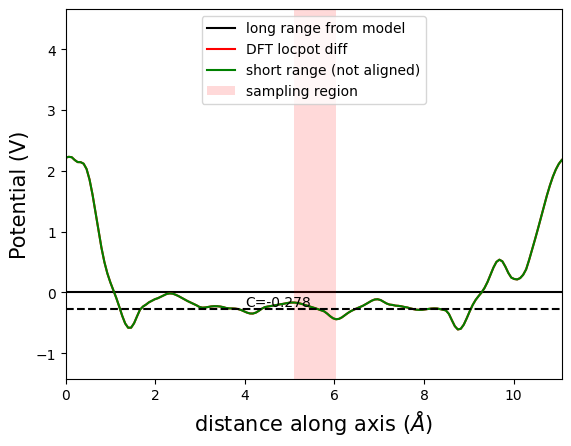

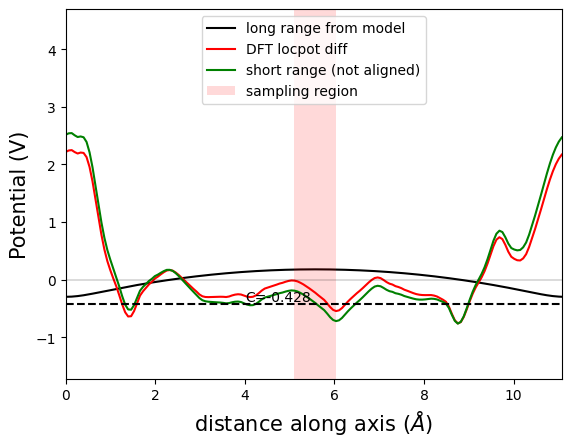

In [9]:
test_defect_entry(defect_entries_and_plot_data_Mg_Ga(data_Mg_Ga(test_dir()), defect_Mg_Ga(gan_struct(test_dir()))), data_Mg_Ga(test_dir()))

In [10]:
def formation_energy_diagram(
    data_Mg_Ga, defect_entries_and_plot_data_Mg_Ga, stable_entries_Mg_Ga_N
):
    bulk_vasprun = data_Mg_Ga["bulk_sc"]["vasprun"]
    bulk_bs = bulk_vasprun.get_band_structure()
    vbm = bulk_bs.get_vbm()["energy"]
    bulk_entry = bulk_vasprun.get_computed_entry(inc_structure=False)
    defect_entries, _ = defect_entries_and_plot_data_Mg_Ga

    def_ent_list = list(defect_entries.values())
    # test the constructor with materials project phase diagram
    atomic_entries = list(
        filter(lambda x: len(x.composition.elements) == 1, stable_entries_Mg_Ga_N)
    )
    pd = PhaseDiagram(stable_entries_Mg_Ga_N)

    # test basic constructor
    fed_ = FormationEnergyDiagram(
        bulk_entry=bulk_entry,
        defect_entries=def_ent_list,
        vbm=vbm,
        pd_entries=stable_entries_Mg_Ga_N,
        inc_inf_values=True,  # include the two additional points at infinity
    )
    assert len(fed_.chempot_limits) == 5

    # test the constructor with atomic entries
    # this is the one we will use for the rest of the tests
    fed = FormationEnergyDiagram.with_atomic_entries(
        defect_entries=def_ent_list,
        atomic_entries=atomic_entries,
        vbm=vbm,
        inc_inf_values=False,
        phase_diagram=pd,
        bulk_entry=bulk_entry,
    )
    assert len(fed.chempot_limits) == 3

    # dataframe conversion
    df = fed.as_dataframe()
    assert df.shape == (4, 5)

    # test that you can get the Ga-rich chempot
    cp = fed.get_chempots(rich_element=Element("Ga"))
    assert cp[Element("Ga")] == pytest.approx(0, abs=1e-2)

    return fed

In [16]:

def test_formation_energy_diagram_shape_fixed(formation_energy_diagram) -> None:
    fed = copy.deepcopy(formation_energy_diagram)

    # check that the shape of the formation energy diagram does not change
    cp_dict = fed.chempot_limits[0]
    form_en = np.array(fed.get_transitions(cp_dict, 0, 5))
    x_ref = form_en[:, 0]
    y_ref = form_en[:, 1]
    y_ref = y_ref - y_ref.min()
    print(x_ref.tolist())
    print(y_ref.tolist())
    for point in fed.chempot_limits:
        form_en = np.array(fed.get_transitions(point, 0, 5))
        x = form_en[:, 0]
        y = form_en[:, 1]
        y = y - y.min()
        print(x.tolist())
        print(y.tolist())
        assert np.allclose(x, x_ref)
        assert np.allclose(y, y_ref)
test_formation_energy_diagram_shape_fixed(formation_energy_diagram(data_Mg_Ga(test_dir()), defect_entries_and_plot_data_Mg_Ga(data_Mg_Ga(test_dir()), defect_Mg_Ga(gan_struct(test_dir()))), loadfn(test_dir() / "stable_entries_Mg_Ga_N.json")))

/Users/siyuliu/anaconda3/envs/macbot/lib/python3.11/site-packages/pymatgen/io/vasp/outputs.py:1182: UserWarning: No POTCAR file with matching TITEL fields was found in

  warnings.warn("No POTCAR file with matching TITEL fields was found in\n" + "\n  ".join(potcar_paths))


[0.0, 0.4230302543993645, 4.302142813614765, 5.0]
[5.274826931985871, 5.274826931985871, 1.3957143727704704, 0.0]
[0.0, 0.4230302543993645, 4.302142813614765, 5.0]
[5.274826931985871, 5.274826931985871, 1.3957143727704704, 0.0]
[0.0, 0.4230302543993647, 4.302142813614765, 5.0]
[5.274826931985871, 5.274826931985871, 1.3957143727704704, 0.0]
[0.0, 0.4230302543993645, 4.302142813614765, 5.0]
[5.274826931985871, 5.274826931985871, 1.3957143727704704, 0.0]


In [19]:
def test_formation_from_directory(
    test_dir, stable_entries_Mg_Ga_N, defect_Mg_Ga
) -> None:
    sc_dir = test_dir / "Mg_Ga"
    qq = []
    for q in [-1, 0, 1]:
        qq.append(q)
        dmap = {"bulk": sc_dir / "bulk_sc"}
        dmap.update(zip(qq, map(lambda x: sc_dir / f"q={x}", qq)))
        
        assert len(dmap) == len(qq) + 1
        fed = FormationEnergyDiagram.with_directories(
            directory_map=dmap,
            defect=defect_Mg_Ga,
            pd_entries=stable_entries_Mg_Ga_N,
            dielectric=10,
        )
        trans = fed.get_transitions(fed.chempot_limits[1], x_min=-100, x_max=100)
        
        assert len(trans) == 1 + len(qq)
    print(len(dmap))
    print(len(trans))

In [20]:
test_formation_from_directory(test_dir(), loadfn(test_dir() / "stable_entries_Mg_Ga_N.json"), defect_Mg_Ga(gan_struct(test_dir())))

4
4


In [3]:
import numpy as np
print(np.ones((3, 5)) * 2)

[[2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]]


In [4]:
from collections import namedtuple
import numpy as np
import pandas as pd
import pytest
from pymatgen.analysis.defects.ccd import (
    HarmonicDefect,
    _get_wswq_slope,
    plot_pes,
)
from pymatgen.analysis.defects.plotting.optics import plot_optical_transitions
from pymatgen.io.vasp.outputs import Waveder

In [8]:
def test_dielectric_func(test_dir) -> None:
    dir0_opt = test_dir / "v_Ga" / "ccd_0_-1" / "optics"
    hd0 = HarmonicDefect.from_directories(
        directories=[dir0_opt],
        store_bandstructure=True,
    )
    hd0.waveder = Waveder.from_binary(dir0_opt / "WAVEDER")
    energy, eps_vbm, eps_cbm = hd0.get_dielectric_function(idir=0, jdir=0)
    inter_vbm = np.trapz(np.imag(eps_vbm[:100]), energy[:100])
    inter_cbm = np.trapz(np.imag(eps_cbm[:100]), energy[:100])
    assert pytest.approx(inter_vbm, abs=0.01) == 6.31
    assert pytest.approx(inter_cbm, abs=0.01) == 0.27

    df, cmap, norm = plot_optical_transitions(hd0, kpt_index=0, band_window=5)
    assert isinstance(df, pd.DataFrame)
    assert len(df) == 11

    df, cmap, norm = plot_optical_transitions(
        hd0,
        kpt_index=-100,
        band_window=5,
        user_defect_band=(100, 0, 0),
        shift_eig={100: 0},
    )
    assert df.iloc[5]["ib"] == 100
    assert df.iloc[5]["jb"] == 100

/Users/siyuliu/anaconda3/envs/macbot/lib/python3.11/site-packages/pymatgen/analysis/defects/ccd.py:618: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(f, Q, energy)
552it [00:00, 37039.35it/s]
312it [00:00, 36918.77it/s]


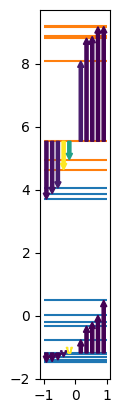

In [9]:
test_dielectric_func(test_dir())

In [17]:
import numpy as np
from pymatgen.analysis.defects.supercells import (
    get_sc_fromstruct,
)
def test_supercells(gan_struct) -> None:
    uc = gan_struct.copy()
    sc_mat = get_sc_fromstruct(uc)
    sc = uc * sc_mat
    print(sc_mat)
    print(sc)
    print(uc)

    # sc_mat2, _ = get_matched_structure_mapping(uc, sc)
    # assert sc_mat2.shape == (3, 3)
    # sc2 = uc * sc_mat2
    # np.testing.assert_allclose(
    #     sc.lattice.abc, sc2.lattice.abc
    # )  # the sc_mat can be reconstructed from the sc

In [18]:
print(test_supercells(gan_struct(test_dir())))

[[ 4  4  0]
 [-2  2  0]
 [ 0  0  2]]
Full Formula (Ga64 N64)
Reduced Formula: GaN
abc   :  12.865160  11.141556  10.479924
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (128)
  #  SP        a         b        c
---  ----  -----  --------  -------
  0  Ga    0.125  0.416666  0.24956
  1  Ga    0.125  0.416666  0.74956
  2  Ga    0.25   0.666666  0.24956
  3  Ga    0.25   0.666666  0.74956
  4  Ga    0.125  0.916667  0.24956
  5  Ga    0.125  0.916667  0.74956
  6  Ga    0.25   0.166667  0.24956
  7  Ga    0.25   0.166667  0.74956
  8  Ga    0.375  0.416666  0.24956
  9  Ga    0.375  0.416666  0.74956
 10  Ga    0.5    0.666666  0.24956
 11  Ga    0.5    0.666666  0.74956
 12  Ga    0.375  0.916667  0.24956
 13  Ga    0.375  0.916667  0.74956
 14  Ga    0.5    0.166667  0.24956
 15  Ga    0.5    0.166667  0.74956
 16  Ga    0.625  0.416666  0.24956
 17  Ga    0.625  0.416666  0.74956
 18  Ga    0.75   0.666666  0.24956
 19  Ga    0.75   0.666666 

In [21]:
sorted([[0, 0, 0], [0.25, 0.25, 0.25], [0.5, 0.5, 0.5], [0.75, 0.75, 0.75]])

[[0, 0, 0], [0.25, 0.25, 0.25], [0.5, 0.5, 0.5], [0.75, 0.75, 0.75]]

In [22]:
import numpy as np
from pymatgen.analysis.defects.utils import (
    get_avg_chg,
)
from pymatgen.io.vasp.outputs import Chgcar
def test_get_avg_chg(gan_struct) -> None:
    data = np.ones((48, 48, 48))
    chgcar = Chgcar(poscar=gan_struct, data={"total": data})
    fpos = [0.1, 0.1, 0.1]
    avg_chg_sphere = get_avg_chg(chgcar, fpos)
    print(avg_chg_sphere)
    avg_chg = np.sum(chgcar.data["total"]) / chgcar.ngridpts / chgcar.structure.volume
    print(avg_chg)


In [23]:
test_get_avg_chg(gan_struct(test_dir()))

0.021302511375915358
0.021302511375915358


In [33]:
from pymatgen.analysis.defects.utils import (
    ChargeInsertionAnalyzer,
)
def chgcar_fe3o4(test_dir):
    return Chgcar.from_file(test_dir / "CHGCAR.Fe3O4.vasp")
def test_chgcar_insertion(chgcar_fe3o4) -> None:
    chgcar = chgcar_fe3o4
    insert_ref = [
        (
            0.03692438178614583,
            [[0.0, 0.0, 0.0], [0.0, 0.0, 0.5], [0.0, 0.5, 0.0], [0.5, 0.0, 0.0]],
        ),  # corners and edge centers
        (
            0.10068764899215804,
            [[0.375, 0.375, 0.375], [0.625, 0.625, 0.625]],
        ),  # center of Fe-O cages
    ]
    cia = ChargeInsertionAnalyzer(chgcar)
    insert_groups = cia.filter_and_group(max_avg_charge=0.5)
    for avg_chg, group in insert_groups:
        print(avg_chg)
        print(group)

In [34]:
test_chgcar_insertion(chgcar_fe3o4(test_dir()))

0.036924381786179954
[[0.0, 0.0, 0.5], [0.0, 0.5, 0.0], [0.5, 0.0, 0.0], [0.0, 0.0, 0.0]]
0.1006876477006408
[[0.375, 0.375, 0.375], [0.625, 0.625, 0.625]]


In [2]:
import numpy as np
from pymatgen.analysis.defects.recombination import (
    pchip_eval,
)
def test_pchip_eval() -> None:
    x_c = np.linspace(0, 2, 5)
    y_c = np.sin(x_c) + 1
    xx = np.linspace(-3, 3, 1000)
    fx = pchip_eval(xx, x_coarse=x_c, y_coarse=y_c)
    int_val = np.trapz(np.nan_to_num(fx), x=xx)
    int_ref = np.sum(y_c)
    print(int_val)
    print(int_ref)
    # assert int_val == pytest.approx(int_ref, rel=1e-3)
test_pchip_eval()

8.229095652886732
8.227688936841835


In [3]:
from pymatgen.analysis.defects.recombination import (
    get_Rad_coef,
)
get_Rad_coef(
        T=[100, 200, 300],
        dQ=1.0,
        dE=1.0,
        omega_i=0.2,
        omega_f=0.2,
        omega_photon=0.6,
        dipole_me=1,
        volume=1,
        g=1,
    )

array([6.97397183e-31, 6.98245178e-31, 7.38666936e-31], dtype=float64)

In [4]:
import os

def count_folders_in_directory(directory_path):
    return sum(os.path.isdir(os.path.join(directory_path, name)) for name in os.listdir(directory_path))

directory_path = "/Users/siyuliu/Desktop/MacBot/src/question_segments/pymatgen_analysis_defects"
folder_count = count_folders_in_directory(directory_path)
print(f"Number of folders: {folder_count}")


Number of folders: 49
